Intro:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.69411767..0.49803925].


Training samples: 10175
Classes: ['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']


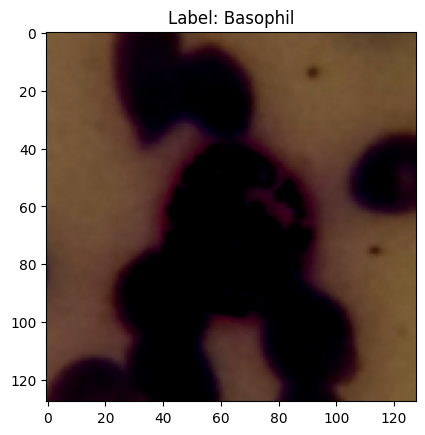

In [1]:
# Data
import numpy as np
import math
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


transform = transforms.Compose([
    transforms.Resize((128, 128)),  #resize all images to 128x128
    transforms.ToTensor(),         #convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


train_dataset = datasets.ImageFolder(root='dataset/Train', transform=transform)
testA_dataset = datasets.ImageFolder(root='dataset/TestA', transform=transform)
testB_dataset = datasets.ImageFolder(root='dataset/Test-B', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testA_loader = DataLoader(testA_dataset, batch_size=32, shuffle=False)
testB_loader = DataLoader(testB_dataset, batch_size=32, shuffle=False)


# TEST AND VISUALIZE DATASET BELOW ------------------------------------------------
print(f"Training samples: {len(train_dataset)}")
print(f"Classes: {train_dataset.classes}")

import matplotlib.pyplot as plt
image, label = train_dataset[0]  #this shows the first image under the train dataset (first image under basophil)
plt.imshow(image.permute(1, 2, 0))  #convert (C, H, W) to (H, W, C) so matplotlib can recognize image.
plt.title(f"Label: {train_dataset.classes[label]}")
plt.show() # Note!!! The image is normalized, so it looks pretty dark when plt.show().


In [2]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
import torch, math, itertools, copy, random
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import KFold            # only external dep.
SEED = 42
torch.manual_seed(SEED); random.seed(SEED)

# --------------------------------------------------------------------------
tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

root = "dataset/Train"                               # <── only 1 root!
full_ds = datasets.ImageFolder(root, transform=tfm)
num_classes = len(full_ds.classes)
print(f"Total imgs: {len(full_ds)}   classes: {full_ds.classes}")


import torch.nn as nn, torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, nf=16, dropout=0.3, num_classes=3):
        super().__init__()
        self.conv1 = nn.Conv2d(3, nf, 5)
        self.conv2 = nn.Conv2d(nf, nf, 5)
        self.conv3 = nn.Conv2d(nf, nf * 2, 5)
        self.pool  = nn.MaxPool2d(2)
        # 128x128  →  pool twice (÷4)  →  32×32  →  conv3 pad-less 5-kern ⇒ 28×28
        flat = (nf * 2) * 28 * 28
        self.fc1  = nn.Linear(flat, 256)
        self.fc2  = nn.Linear(256, num_classes)
        self.dp   = dropout

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dp, training=self.training)
        return self.fc2(x)

def make_model(hp):                       # hp = dict of hyper-parameters
    return CNN(nf=hp["nf"], dropout=hp["drop"], num_classes=num_classes)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

def run_epoch(model, loader, optimizer=None, device=device):
    train = optimizer is not None
    model.train(train)
    loss_fn = nn.CrossEntropyLoss()
    running, correct = 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        if train: optimizer.zero_grad()
        out  = model(x)
        loss = loss_fn(out, y)
        if train:
            loss.backward(); optimizer.step()
        running += loss.item() * y.size(0)
        correct += (out.argmax(1) == y).sum().item()
    n = len(loader.dataset)
    return running / n, correct / n            # mean loss, accuracy

EPOCHS = 6
kfold  = KFold(n_splits=5, shuffle=True, random_state=SEED)

param_grid = {                      # expand later!
    "lr"   : [3e-4, 1e-3],
    "nf"   : [16, 32],
    "drop" : [0.25, 0.4],
    "bs"   : [32],                  # keep batch size fixed for now
}

def product(d):
    keys, vals = zip(*d.items())
    for combo in itertools.product(*vals):
        yield dict(zip(keys, combo))

results = []

for hp in product(param_grid):
    print(f"\n▶ Testing hyper-params: {hp}")
    fold_metrics = []
    for fold, (idx_tr, idx_val) in enumerate(kfold.split(range(len(full_ds))), 1):
        tr_ds  = Subset(full_ds, idx_tr)
        val_ds = Subset(full_ds, idx_val)
        tr_ld  = DataLoader(tr_ds,  batch_size=hp["bs"], shuffle=True,  num_workers=2)
        val_ld = DataLoader(val_ds, batch_size=hp["bs"], shuffle=False, num_workers=2)

        model     = make_model(hp).to(device)
        optim     = torch.optim.Adam(model.parameters(), lr=hp["lr"])

        # ---------- tiny training loop ----------
        for _ in range(EPOCHS):
            run_epoch(model, tr_ld, optim, device)
        _, acc = run_epoch(model, val_ld, None, device)
        fold_metrics.append(acc)
        print(f"  Fold {fold}: val_acc = {acc:.3%}")

    mean_acc = sum(fold_metrics) / len(fold_metrics)
    results.append((mean_acc, hp))
    print(f"  → mean 5-fold accuracy: {mean_acc:.3%}")

best_acc, best_hp = max(results, key=lambda x: x[0])
print("\nBest setting:", best_hp, f"with {best_acc:.2%} accuracy")

best_model   = make_model(best_hp).to(device)
train_loader = DataLoader(full_ds, batch_size=best_hp["bs"], shuffle=True)
optim        = torch.optim.Adam(best_model.parameters(), lr=best_hp["lr"])

for epoch in range(15):                             # full training now
    tr_loss, tr_acc = run_epoch(best_model, train_loader, optim, device)
    print(f"Epoch {epoch+1:>2}: loss {tr_loss:.4f}  acc {tr_acc:.3%}")



Total imgs: 10175   classes: ['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']

▶ Testing hyper-params: {'lr': 0.0003, 'nf': 16, 'drop': 0.25, 'bs': 32}
  Fold 1: val_acc = 94.398%
  Fold 2: val_acc = 93.268%
  Fold 3: val_acc = 94.791%
  Fold 4: val_acc = 93.661%
  Fold 5: val_acc = 94.251%
  → mean 5-fold accuracy: 94.074%

▶ Testing hyper-params: {'lr': 0.0003, 'nf': 16, 'drop': 0.4, 'bs': 32}
  Fold 1: val_acc = 93.366%
  Fold 2: val_acc = 94.791%
  Fold 3: val_acc = 95.086%
  Fold 4: val_acc = 95.135%
  Fold 5: val_acc = 95.332%
  → mean 5-fold accuracy: 94.742%

▶ Testing hyper-params: {'lr': 0.0003, 'nf': 32, 'drop': 0.25, 'bs': 32}


KeyboardInterrupt: 

Explaining CNN

In [4]:
# Vision Transformer
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Image size for ViT/ResNet
IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # For grayscale images adjust if needed
])

train_dataset = datasets.ImageFolder('dataset/Train', transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

Conclusion:
